<a href="https://colab.research.google.com/github/motorlearner/neuromatch/blob/main/laquitaine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
# imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [54]:
# @title Read Data
# ---------------------------------------------------------------------------- #


# fetch data
url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)

# read data
data = pd.read_csv("data01_direction4priors.csv")

In [49]:
# @title Helpers: Process Data
# ---------------------------------------------------------------------------- #


# COORDINATE TRANSFORMS ------------------------------------------------------ #

def cart2pol(x:np.array, y:np.array):
  """
  Convert cartesian `(x,y)` to polar `(deg,mag)`.

  Args:
      `x`: scalar or array of x-coordinates
      `y`: scalar or array of y-coordinates

  Returns:
      Tuple of `(deg,mag)`, where `deg` is in the interval
      [0,360) counterclockwise from the positive x axis.
  """
  # checks
  # compute
  deg = (np.degrees(np.arctan2(y,x)) + 360) % 360
  mag = np.hypot(x,y)
  return deg,mag


def cart2deg(x:np.array, y:np.array):
  return cart2pol(x,y)[0]


def cart2mag(x:np.array, y:np.array):
  return cart2pol(x,y)[1]


def pol2cart(deg: np.array, mag: np.array):
  """
  Convert polar `(deg,mag)` to cartesian `(x,y)`.

  Args:
      `deg`: scalar or array of angles in degrees [0,360)
      `mag`: scalar or array of magnitudes

  Returns:
      Tuple of `(x, y)` coordinates.
  """
  # Convert degrees to radians
  rad = np.radians(deg)
  # Compute x and y
  x = mag * np.cos(rad)
  y = mag * np.sin(rad)
  return x, y

# CIRCULAR DISTANCE ---------------------------------------------------------- #

def circdiff(angle:np.array, reference:np.array):
  """
  Compute the signed minimal circular distance from `angle` to `reference`.

  Args:
      `angle`: scalar or array of angles in degrees [0, 360)
      `reference`: scalar reference angle in degrees [0, 360)

  Returns:
      Signed circular distance in degrees (-180, 180].
  """
  return ((angle - reference + 180) % 360) - 180

In [154]:
df = data.copy()
# stimulus relative to prior
df['motion_direction_rel'] = circdiff(df.motion_direction, df.prior_mean)
# polar estimate
df['estimate_deg'], df['estimate_mag'] = cart2pol(df.estimate_x, df.estimate_y)
df['estimate_deg_rel'] = circdiff(df.estimate_deg, df.prior_mean)
# error (deg)
df['error'] = circdiff(df.estimate_deg, df.motion_direction)
# error (deg) +ve if towards prior_mean (even if overshoots)
df['prioratt'] = np.where(df.motion_direction_rel *  (e := df.error) < 0, np.abs(e), -np.abs(e))
df['prioratt_norm'] = np.where((mdr := df.motion_direction_rel) != 0, df.error / mdr, np.nan)

df.columns

Index(['trial_index', 'trial_time', 'response_arrow_start_angle',
       'motion_direction', 'motion_coherence', 'estimate_x', 'estimate_y',
       'reaction_time', 'raw_response_time', 'prior_std', 'prior_mean',
       'subject_id', 'experiment_name', 'experiment_id', 'session_id',
       'run_id', 'motion_direction_rel', 'estimate_deg', 'estimate_mag',
       'estimate_deg_rel', 'error', 'prioratt', 'prioratt_norm'],
      dtype='object')

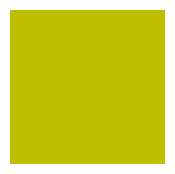

In [119]:
# @title Helpers: Plots
# ---------------------------------------------------------------------------- #

# PARAMS / SETTINGS ---------------------------------------------------------- #

colormap = {
    80: [0.5, 0, 0],
    40: [1, 0.2, 0],
    20: [1, 0.6, 0],
    10: [0.75, 0.75, 0]
}

# FUNCTIONS ------------------------------------------------------------------ #

def show_color(color):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

In [165]:
def plot_rawdata(subject_id:int):
  dat = df[df.subject_id == subject_id]

  session_ids  = np.sort(dat.session_id.unique())
  run_ids      = np.sort(dat.run_id.unique())
  session_runs = dat.groupby('session_id')['run_id'].nunique().max()

  coherence_set = np.sort(dat['motion_coherence'].unique())
  priorstd_set  = np.sort(dat['prior_std'].unique())


  fig, axs = plt.subplots(len(run_ids), len(coherence_set), figsize=(2.5*len(coherence_set), 2.5*len(run_ids)))

  # if axs is 1D (i.e. only 1 run or coherence), make it 2D for uniform indexing
  if len(run_ids) == 1 and len(coherence_set) == 1:
      axs = np.array([[axs]])
  elif len(run_ids) == 1:
      axs = axs[np.newaxis, :]
  elif len(coherence_set) == 1:
      axs = axs[:, np.newaxis]

  for i, run_id in enumerate(run_ids):
      for j, coherence in enumerate(coherence_set):
          ax = axs[i, j]
          ax.set_xlim(-180, 180)
          ax.set_ylim(-180, 180)
          ax.set_aspect('equal', adjustable='box')
          ax.set_title(f"Run {run_ids[i]}, Coherence {coherence_set[j]:.0%}", fontsize=9)
          ax.set_xticks(np.linspace(-180,180,5))
          ax.set_yticks(np.linspace(-180,180,5))

          # Hide x tick labels except for bottom row
          if i < len(run_ids) - 1:
              ax.set_xticklabels([])

          # Hide y tick labels except for leftmost column
          if j > 0:
              ax.set_yticklabels([])

          ax.set_xlabel("Stimulus vs. Prior Mean" if i == len(run_ids) - 1 else "")
          ax.set_ylabel("Estimate vs. Prior Mean" if j == 0 else "")


          # Filter data for this run and coherence
          subset = dat[(dat['run_id'] == run_id) & (dat['motion_coherence'] == coherence)]
          prior_std = subset.prior_std.unique()[0]

          # Scatter plot stimulus_direction vs response_deg
          ax.axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=0.5)
          ax.scatter(
              subset.motion_direction_rel, subset.estimate_deg_rel,
              s=10, alpha=0.7, color=colormap[prior_std]
          )
          ax.text(
            0.98, 0.02, f"n={len(subset)}", transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8, color='black'
          )



  run_id_to_row = {run: i for i, run in enumerate(run_ids)}
  session_to_firstrun = dat.groupby('session_id')['run_id'].min().to_dict()

  for session_id in session_ids:
      first_run_id = session_to_firstrun[session_id]
      row_idx = np.flatnonzero(run_ids == first_run_id)[0]
      ax = axs[row_idx, 0]  # first column of that run's row

      # Add session label on left of that subplot
      ax.annotate(
          f"Session {session_id}",
          xy=(-0.5, 0.5), xycoords='axes fraction',
          rotation=90,
          va='center',
          ha='right',
          fontsize=12,
          fontweight='bold'
      )

  plt.tight_layout()
  plt.show()


slider = widgets.IntSlider(value=1, min=1, max=12, step=1, description='Subject')

plotoutput = widgets.interactive_output(plot_rawdata, {'subject_id': slider})

container = widgets.VBox([slider, plotoutput])

display(container)